# Scikit-learn

In [2]:
import csv
import pandas as pd
import sklearn

In [3]:
df = pd.read_csv("../dataset/loan.csv.zip", parse)
df.head(3)


/home/db/bin/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.columns[[19,47,55,112,123,124,125,128,129,130,133,139,140,141]]

Index(['desc', 'next_pymnt_d', 'verification_status_joint',
       'sec_app_earliest_cr_line', 'hardship_type', 'hardship_reason',
       'hardship_status', 'hardship_start_date', 'hardship_end_date',
       'payment_plan_start_date', 'hardship_loan_status',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date'],
      dtype='object')

In [7]:
df.dtypes

id                       float64
member_id                float64
loan_amnt                  int64
funded_amnt                int64
funded_amnt_inv          float64
                          ...   
settlement_status         object
settlement_date           object
settlement_amount        float64
settlement_percentage    float64
settlement_term          float64
Length: 145, dtype: object

In [21]:
print df.count()

member_id                      887379
loan_amnt                      887379
funded_amnt                    887379
funded_amnt_inv                887379
term                           887379
int_rate                       887379
installment                    887379
grade                          887379
sub_grade                      887379
emp_title                      835922
emp_length                     887379
home_ownership                 887379
annual_inc                     887375
verification_status            887379
issue_d                        887379
loan_status                    887379
pymnt_plan                     887379
url                            887379
desc                           126029
purpose                        887379
title                          887228
zip_code                       887379
addr_state                     887379
dti                            887379
delinq_2yrs                    887350
earliest_cr_line               887350
inq_last_6mt

### selecting dimensions

In [22]:
selected = []
n = 887350
for col, count in zip(df.columns, df.count()):
    if count >= n:
        selected.append(col)
print selected
print len(selected)
data = df[selected]

['member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'purpose', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'policy_code', 'application_type', 'acc_now_delinq']
42


In [23]:
df.loan_status.value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

### select rows

In [24]:
status = ['Fully Paid','Default', 'Charged Off', 'Does not meet the credit policy. Status:Charged Off']
data = data.loc[data.loan_status.isin(status)]

### cleaning and processing

In [25]:
data = data[selected]
data = data.dropna(thresh=len(selected))
print "Number of NaNs: %d" % (data.isnull().values.sum())

data['label'] = data['loan_status'].apply(lambda x : +1 if x=='Fully Paid' else -1)
default = data.loc[data['label'] == -1]
paid = data.loc[data['label'] == 1]
print "Percentage of safe loans  : %s " % (len(paid)* 100.0 / (len(default) + len(paid)))
print "Percentage of risky loans : %s " % (len(default)* 100.0 / (len(default) + len(paid)))

Number of NaNs: 0
Percentage of safe loans  : 81.4766148391 
Percentage of risky loans : 18.5233851609 


### selecting features to use in this baseline approach

In [26]:
features = ['emp_length',                # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'term',                      # the term of the loan
            'loan_amnt',                 # loan amount
            'annual_inc',                # annual income           
            'total_acc',                 # num accounts
            'delinq_2yrs'                # num accounts
           ]           

### creating balanced datasets

In [27]:
percentage = len(default)/float(len(paid))
risky_loans = default
safe_loans = paid.sample(frac=percentage)

dataset_x = risky_loans[features].append(safe_loans[features])
dataset_y = risky_loans.label.append(safe_loans.label)

### encoding features

In [28]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(dataset_x.purpose.unique())
dataset_x.purpose = le.transform(dataset_x.purpose)

le2 = preprocessing.LabelEncoder()
le2.fit(dataset_x.home_ownership.unique())
dataset_x.home_ownership = le2.transform(dataset_x.home_ownership)

dataset_x.emp_length = dataset_x.emp_length.apply(lambda x: x[:-6] if 'years' in x else '0')
dataset_x.emp_length = dataset_x.emp_length.apply(lambda x: float(x[:-1]) if '+' in x else float(x))
dataset_x.term = dataset_x.term.apply(lambda x: float(x.replace("months","")))

print len(dataset_x), len(dataset_y)

94450 94450


### training + cross-validation

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate

clf = RandomForestClassifier(n_estimators=500)
scoring = {'accuracy': make_scorer(accuracy_score),'prec': 'precision'}
cv_results = cross_validate(clf.fit(dataset_x, dataset_y), dataset_x, dataset_y, scoring=scoring)

#one versus all
print cv_results

{'train_accuracy': array([ 1.        ,  0.99998412,  1.        ]), 'score_time': array([ 7.81586194,  8.23215008,  8.20141602]), 'fit_time': array([ 44.10710502,  43.85120201,  44.11725187]), 'test_accuracy': array([ 0.57190954,  0.58763181,  0.59332317]), 'test_prec': array([ 0.56595968,  0.58312745,  0.59165211]), 'train_prec': array([ 1.,  1.,  1.])}


### ROC curve and AUC

In [30]:
# Receiver operating characteristic 
# TPR = true positive rate vs. FPR = false positive rate, at various threshold settings
# Here FPR is better -> specificity = 1 - FPR 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, n_estimators in enumerate([1, 10, 50, 100, 300, 500, 1000, 2000]):
    clf = RandomForestClassifier(n_estimators)
    X_train, X_test, y_train, y_test = train_test_split(dataset_x, dataset_y, test_size=0.2, random_state=42)
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    fpr[i], tpr[i], _ = roc_curve(y_predict, y_test, pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
print roc_auc

{0: 0.54250582822283944, 1: 0.57655656415128598, 2: 0.59913202230494333, 3: 0.60031466484535079, 4: 0.60420417954387295, 5: 0.602775775023359, 6: 0.602906115927903, 7: 0.60278413091346128}


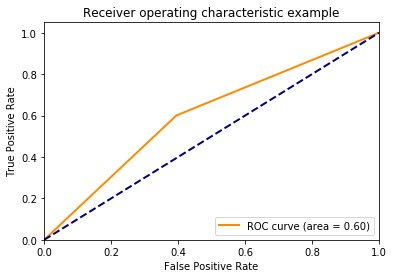

In [34]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(fpr[5], tpr[5], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[5])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()